In [ ]:
import os

# Set the environment variable to enable CPU fallback for MPS
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
%env PYTORCH_ENABLE_MPS_FALLBACK=1

In [ ]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, ConcatDataset, random_split, DataLoader, Dataset

import numpy as np

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
    
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
    
else:
    print ("MPS device not found.")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

mnist_train = torchvision.datasets.MNIST(
    root='./Data',
    train=True,
    download=True,
    transform=transform,
)
mnist_train.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)

train_loader = torch.utils.data.DataLoader(
    mnist_train, 
    shuffle=True,
    batch_size=64,
)

mnist_test = torchvision.datasets.MNIST(
    root='./Data',
    train=False,
    download=True,
    transform=transform
)
mnist_test.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)

test_loader = torch.utils.data.DataLoader(
    mnist_test,
    shuffle=True,
    batch_size=64,
)

In [42]:
# Let's show some of the training images, for fun.
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# Let's show some of the training images, for fun.
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images)), labels

In [ ]:
images.shape

Define a simple MLP with 2 linear layers and ReLU. This model currently only produces random noise images with a single normally distributed random input. We produce an output vector of 784 and then convert it to a tensor by putting multiples of 28 numbers as the rows of the matrix

In [ ]:
class Generator(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(1, 256)
        self.relu1 = nn.ReLU()
        
        self.linear2 = nn.Linear(256, 784)
        self.relu2 = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = self.relu2(x)
        
        '''# Need to convert the output vector x to a matrix
        g_out_mat = torch.zeros(1, 28, 28)

        m = 0
        n = 0

        for i in range(len(x)):
            if i % 28 == 0 and i != 0:
                m += 1
                n = 0
                #print(i, m)

            g_out_mat[0, m, n] = x[i]

            n += 1  '''
        
        # Reshape the output to a 28x28 matrix
        x = x.view(-1, 28, 28)
        
        return x
    
generator = Generator()

In [ ]:
mu, sigma = 0, 1 # mean and standard deviation
g_in = torch.tensor(np.random.normal(mu, sigma, 1), dtype=torch.float32)
g_in

In [ ]:
g_out = generator(g_in)

In [ ]:
imshow(g_out.detach().cpu()), torch.Tensor([0])

In [ ]:
# Maybe we can perform a check on the above noise output image and check if it is indeed just noise? Would
# be nice for my blog post

### Lets add 50% noise samples to the dataset, we will add 60k to train set and 10k to test
This is optional to run, do not run it right away

In [ ]:
# Lets first generate 70k noise numbers from the normal dist
noise_tensor = torch.randn(70000, 1)

# Will pass each of these to the model to give us 70k noisy images
generator.eval()
with torch.no_grad():
    gen_images = generator(noise_tensor)
    gen_images = gen_images.unsqueeze(1)

gen_labels = [0] * 70000

In [ ]:
imshow(gen_images[0].detach()), gen_labels[0]

In [ ]:
# Create a new dataset
gen_dataset = TensorDataset(gen_images, torch.tensor(gen_labels, dtype=torch.long))

train_size = 60000
test_size = 10000
gen_train_dataset, gen_test_dataset = random_split(gen_dataset, [train_size, test_size])

In [ ]:
# Create a custom dataset class which allows us to keep the labels as integers to match the MNIST data
class CustomTensorDataset(Dataset):
    """Dataset wrapping tensors and integer labels.

    Arguments:
        tensors (Tensor): contains sample data.
        labels (list of int): contains sample labels.
    """
    def __init__(self, tensors, labels):
        assert tensors.size(0) == len(labels)
        self.tensors = tensors
        self.labels = labels

    def __getitem__(self, index):
        return self.tensors[index], self.labels[index]

    def __len__(self):
        return self.tensors.size(0)
    
gen_dataset = CustomTensorDataset(gen_images, gen_labels)

train_size = 60000
test_size = 10000
gen_train_dataset, gen_test_dataset = random_split(gen_dataset, [train_size, test_size])

In [ ]:
comb_train_dataset = ConcatDataset([mnist_train, gen_train_dataset])
comb_test_dataset = ConcatDataset([mnist_test, gen_test_dataset])

# Create DataLoaders for the combined datasets
comb_train_loader = DataLoader(comb_train_dataset, batch_size=64, shuffle=True)
comb_test_loader = DataLoader(comb_test_dataset, batch_size=64, shuffle=False)

In [ ]:
gen_train_dataset[0], mnist_train[2]

***

In [ ]:
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.linear2 = nn.Linear(256, 1)
        #self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        # Use sigmoid to ensure output is a probability
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.linear2(x)
        #x = self.relu2(x)
        #x = self.dropout2(x)
        
        x = self.sigmoid(x)
        
        return x

discriminator = Discriminator()
discriminator.to(device)

Lets feed 1 image at a time, either from train dataset or the generated noise image from our Generator model and train the discriminator. I will try implement a manual training loop, to train on batch size one updating after each epoch. We have labels 1 - Data from training set, 0 - Data from G

In [ ]:
# Lets add the label to the train loader and test loader data. Basically just switch the labels to be all 1s
# Switch all the labels of the mnist train data to 1, which represent true for being from the train set
#mnist_train.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)
#mnist_test.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)
# We run these when we load the original mnist_data such that we do not change labels after adding the noise samples

In [ ]:
# Lets make a function which will provide the input to the discriminator model. We will flatten the input input 
# We will put a random split on the training input, it will either come from the generator model or the training data


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.05, weight_decay=0.0005, momentum=0.9)

In [ ]:
for epoch in range(5):
    discriminator.train()
    i = 0
    data_iter = iter(train_loader)
    running_loss = 0.0

    '''for i, data in enumerate(train_loader, 0):
        # Here I either choose data from the trainset or the generator
    
        inputs, labels = data'''
    
    # Issue with the labels I have no clue what is happening, lets switch tack and try to just train without the 
    # gen samples
    
    while i < len(mnist_train):
        #if torch.rand(1) > 0.5:
        #    mu, sigma = 0, 1 # mean and standard deviation
        #    g_in = torch.Tensor(np.random.normal(mu, sigma, 1))
        #    inputs, labels = generator(g_in)
        #    if i > 0:
        #        i -= 1 # Reset i position
        #    print("gen sample")
        #    print(labels, labels.shape)
            # Convert labels to torch.Tensor and ensure they have the correct shape
            #labels = torch.Tensor(labels).unsqueeze(0)
        #else:
        inputs, labels = next(data_iter)
        #print('train sample')
        #print(f'label: {labels}')
        #print(f'input shape before flattening: {inputs.shape}')
        
    
        # Flatten the input to a vector
        inputs = torch.flatten(inputs, start_dim=1)
        #print(f'input shape after flattening: {inputs.shape}')
        
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        #labels = labels.to(torch.float32)
        optimizer.zero_grad()
        outputs = discriminator(inputs)
        #print(f'outputs shape: {outputs.shape} | labels shape {labels.shape}')
        #print(f'outputs: {outputs} | labels: {labels}')
        
        # Ensure outputs and labels have the same shape
        labels = labels.unsqueeze(1)
        labels = labels.float()
        #print(f'labels shape after view_as: {labels.shape}')
        
        loss = criterion(outputs, labels)
        #print(loss)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        i += 64
 

    # Move this print statement outside the inner loop
    print(f'Epoch [{epoch + 1}] loss: {running_loss / len(train_loader):.3f}')
    running_loss = 0.0

    discriminator.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # Push images to mps gpu
            
            images = torch.flatten(images, start_dim=1)
            labels = labels.unsqueeze(1)
            labels = labels.float()
            
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = discriminator(images)
            # the class with the highest energy is what we choose as prediction
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            #total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / len(mnist_test)
    print(f'Accuracy of the network on the test images: {test_accuracy:.2f}%')

print('Finished Training')

In [ ]:
# Interesting so if the tensors have a different shape i.e (64), (64,1)
# The sum equates to the 64*64 why?

In [ ]:
# Now lets see what happens if we give the model our random noise image
# Doing this makes the model out put roughly 0.5, showing it assigns roughly equal weight to both classes
# I will now generate a bunch of noise samples and add them to the test train set to see what happens
# The addition of noise will be done in a code block above
noise = generator(torch.Tensor(np.random.normal(mu, sigma, 1)))
noise_test = torch.flatten(noise, start_dim=1)
noise_test = noise_test.to(device)
discriminator.eval()
noise_out = discriminator(noise_test)
noise_out

In [ ]:
imshow(noise.detach())

In [ ]:
noise.shape

In [ ]:
test_in = mnist_test[10][0]
test_in = torch.flatten(test_in, start_dim=1)
test_in = test_in.to(device)

discriminator(test_in)

## Running the discriminator with noise added to the mnist_data
Data originally in mnist has label 1 and the noise has label 0

In [ ]:
for epoch in range(5):
    running_loss = 0.0

    for i, data in enumerate(comb_train_loader, 0):
        # Here I either choose data from the trainset or the generator
    
        inputs, labels = data
    
        # Flatten the input to a vector
        inputs = torch.flatten(inputs, start_dim=1)
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = discriminator(inputs)
        
        # Ensure outputs and labels have the same shape
        labels = labels.unsqueeze(1)
        labels = labels.float()
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
         
    # Move this print statement outside the inner loop
    print(f'Epoch [{epoch + 1}] loss: {running_loss / len(train_loader):.3f}')
    running_loss = 0.0

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in comb_test_loader:
            images, labels = data
            # Push images to mps gpu
            
            images = torch.flatten(images, start_dim=1)
            labels = labels.unsqueeze(1)
            labels = labels.float()
            
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = discriminator(images)
            # the class with the highest energy is what we choose as prediction
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            #total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / len(mnist_test + mnist_test)
    print(f'Accuracy of the network on the test images: {test_accuracy:.2f}%')

print('Finished Training')

In [ ]:
data_iter = iter(comb_train_loader)
data = next(data_iter)

## So now I have a dataset which contains some random noise samples and the model classifies either if something is random noise or a image from the dataset

In [154]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

mnist_train = torchvision.datasets.MNIST(
    root='./Data',
    train=True,
    download=True,
    transform=transform,
)
mnist_train.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)

train_loader = torch.utils.data.DataLoader(
    mnist_train, 
    shuffle=True,
    batch_size=batch_size,
)

mnist_test = torchvision.datasets.MNIST(
    root='./Data',
    train=False,
    download=True,
    transform=transform
)
mnist_test.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)

test_loader = torch.utils.data.DataLoader(
    mnist_test,
    shuffle=True,
    batch_size=batch_size,
)

# TODO: We never use the train/test split why not just train with all data?

In [175]:
# I attempt to change the model architecture to get the generator to actually learn something, atm D model dominates
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(784, 1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.linear2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        self.linear3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        
        self.linear4 = nn.Linear(256, 1)
        
        # Use sigmoid to ensure output is a probability
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(x.size(0), 784)
        
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.linear4(x)
        
        x = self.sigmoid(x)
        
        return x

discriminator = Discriminator().to(device)

In [176]:
# I attempt to change the model architecture to get the generator to actually learn something

class Generator(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(100, 256)
        self.relu1 = nn.ReLU()
        
        self.linear2 = nn.Linear(256, 512)
        self.relu2 = nn.ReLU()
        
        self.linear3 = nn.Linear(512, 1024)
        self.relu3 = nn.ReLU()
        
        self.linear4 = nn.Linear(1024, 784)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = self.relu2(x)
        
        x = self.linear3(x)
        x = self.relu3(x)
        
        x = self.linear4(x)
        
        out = self.tanh(x)
        
        # Reshape the output to a 28x28 matrix
        out = out.view(x.size(0) , 1, 28, 28)
        
        return out

generator = Generator().to(device)

In [164]:
# Init two optimizers, one for G and one for D
criterion = nn.BCELoss()

optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)

Epoch 0: Loss_D: 0.5395066738128662, Loss_G: 0.5246632099151611


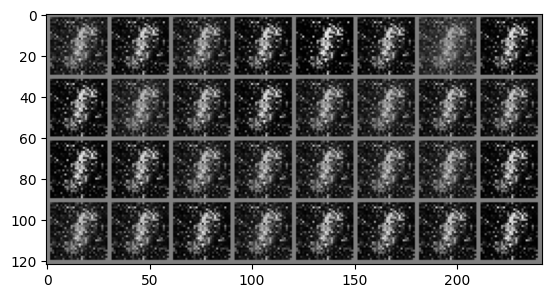

Epoch 1: Loss_D: 0.22673435509204865, Loss_G: 5.0595316886901855


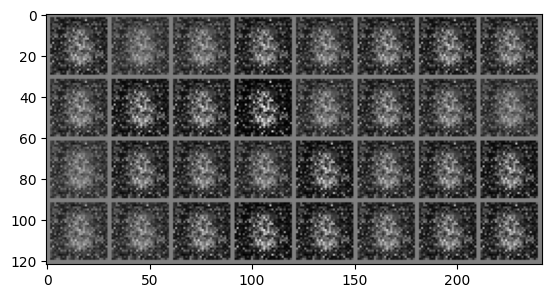

Epoch 2: Loss_D: 0.06313431262969971, Loss_G: 4.179136276245117


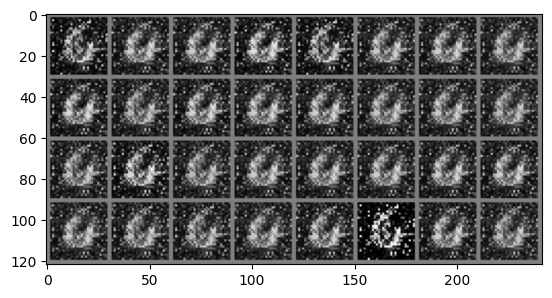

Epoch 3: Loss_D: 0.001664921292103827, Loss_G: 11.765012741088867


KeyboardInterrupt: 

In [165]:
for epoch in range(50):
    for i, data in enumerate(train_loader):
        real_images, _ = data  # We dont care about the MNIST labels we can just generate all 1s to sim them
        real_images = real_images.to(device)
        
        # Sample from noise and generate the fake images
        noise_tensor = torch.randn((batch_size, 100)).to(device) # Increase amount of noise it was 1 before
        with torch.no_grad():
            gen_images = generator(noise_tensor)

        # Create the real and fake labels
        gen_labels = torch.zeros((batch_size, 1)).to(device)
        real_labels = torch.ones((batch_size, 1)).to(device)
        
        # Concat fake and real images
        combined_images = torch.cat((real_images, gen_images)) # Change from [inp, gen] to ()
        combined_labels = torch.cat((real_labels, gen_labels))
                
        # Optional: shuffle the combined batch to prevent the model from learning order
        indices = torch.randperm(combined_images.size(0))
        combined_images = combined_images[indices]
        combined_labels = combined_labels[indices]
                        
        # First update the D model
        discriminator.zero_grad()
        d_outputs_combined = discriminator(combined_images)  
        loss_d = criterion(d_outputs_combined, combined_labels)
        loss_d.backward()
        optimizer_D.step()
        
        # Generate new images for updating G
        noise_tensor = torch.randn((batch_size, 100)).to(device)
        
        # Next update the G model, 
        generator.zero_grad()
        gen_images = generator(noise_tensor)  # Gen new images for training G
        # For generator we need to switch the label from fake 0s, to real 1s
        # Note we use the D model, the equation in the paper is max log(D(G(z))) and we already have G(z)
        d_outputs_generated = discriminator(gen_images)
        loss_g = criterion(d_outputs_generated, real_labels)
        loss_g.backward()
        optimizer_G.step()
        
        if i == batch_size-1:  
            print(f'Epoch {epoch}: Loss_D: {loss_d.item()}, Loss_G: {loss_g.item()}')
            
    imshow(torchvision.utils.make_grid(gen_images.cpu()))

print("Training complete")

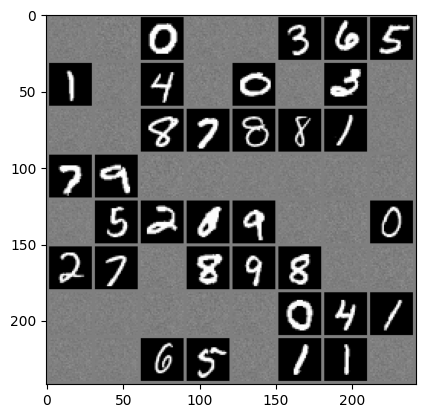

In [133]:
imshow(torchvision.utils.make_grid(images_for_out.cpu()))

## Debugging lets copy and paste the RealPython blog to see why mine is fucking up

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [78]:
torch.manual_seed(111)

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_set = torchvision.datasets.MNIST(
    root="./Data", train=True, download=True, transform=transform
)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

cuda


In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device=device)

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0) , 1, 28, 28)
        return output

generator = Generator().to(device=device)
#generator = Generator()

In [177]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Epoch: 0 Loss D.: 0.5644384026527405
Epoch: 0 Loss G.: 0.47672757506370544


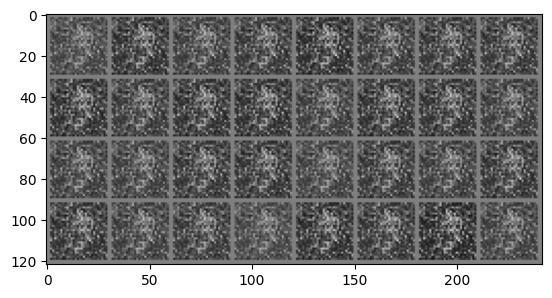

Epoch: 1 Loss D.: 0.028125755488872528
Epoch: 1 Loss G.: 5.387104034423828


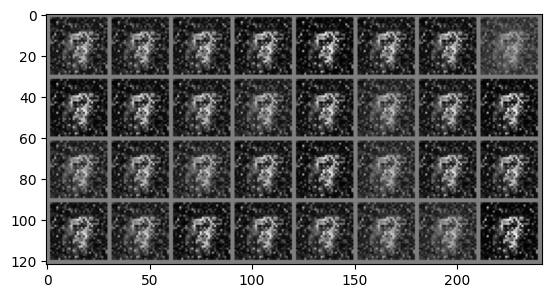

Epoch: 2 Loss D.: 0.018462076783180237
Epoch: 2 Loss G.: 5.597542762756348


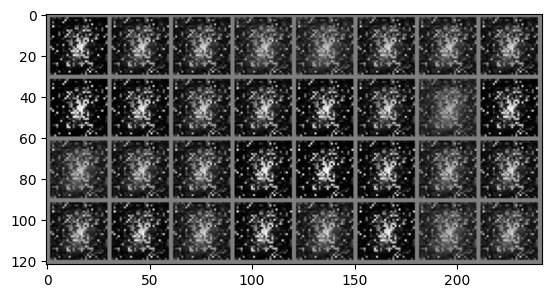

Epoch: 3 Loss D.: 0.006920455954968929
Epoch: 3 Loss G.: 8.649968147277832


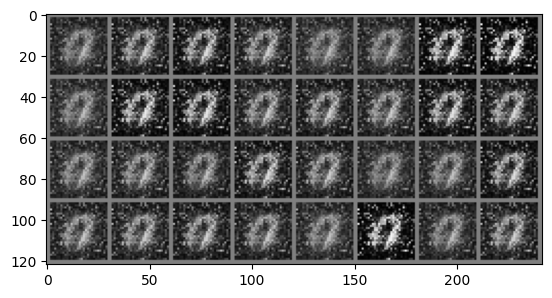

Epoch: 4 Loss D.: 0.12889933586120605
Epoch: 4 Loss G.: 5.004423141479492


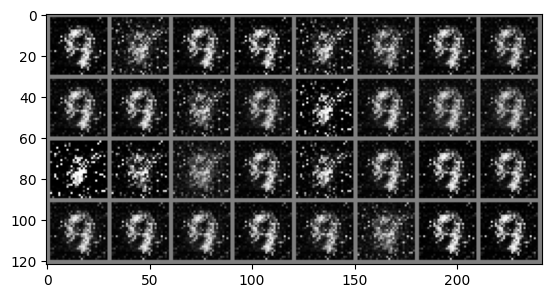

Epoch: 5 Loss D.: 0.028238588944077492
Epoch: 5 Loss G.: 6.547661781311035


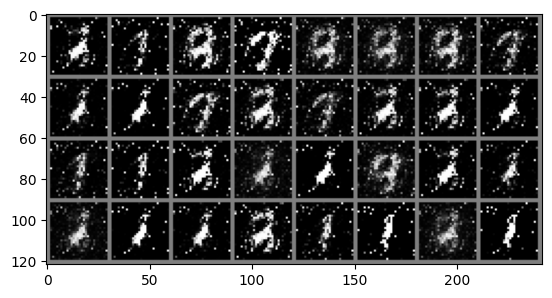

Epoch: 6 Loss D.: 0.0750136598944664
Epoch: 6 Loss G.: 4.304974555969238


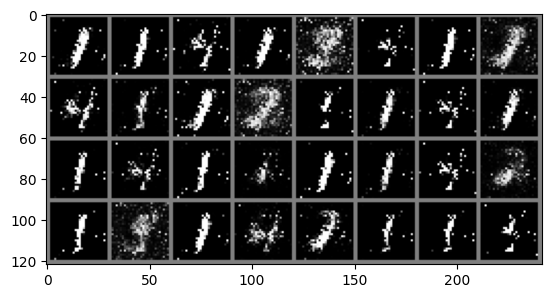

Epoch: 7 Loss D.: 0.17698606848716736
Epoch: 7 Loss G.: 3.6369893550872803


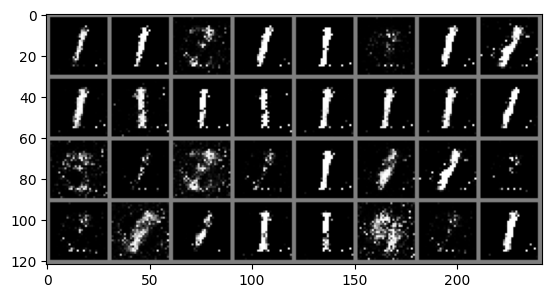

Epoch: 8 Loss D.: 0.1973065733909607
Epoch: 8 Loss G.: 2.8736910820007324


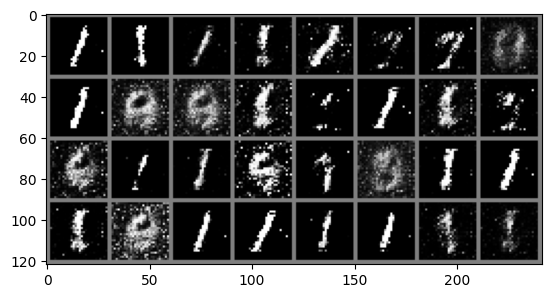

Epoch: 9 Loss D.: 0.36608099937438965
Epoch: 9 Loss G.: 2.2241618633270264


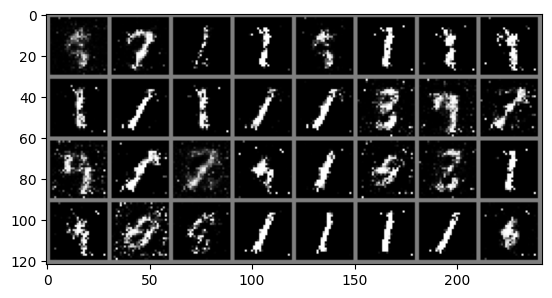

Epoch: 10 Loss D.: 0.3274019956588745
Epoch: 10 Loss G.: 1.6893250942230225


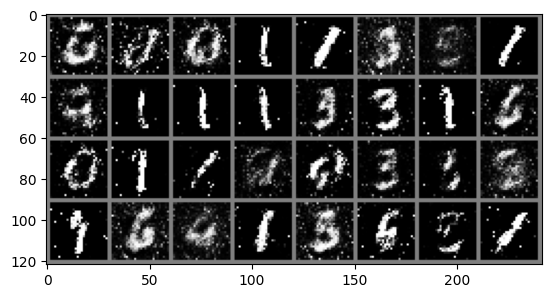

Epoch: 11 Loss D.: 0.387830913066864
Epoch: 11 Loss G.: 1.5896271467208862


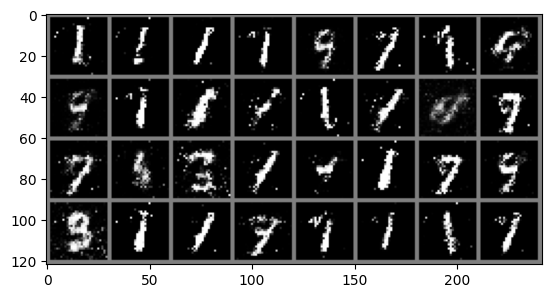

Epoch: 12 Loss D.: 0.3746681213378906
Epoch: 12 Loss G.: 1.5226038694381714


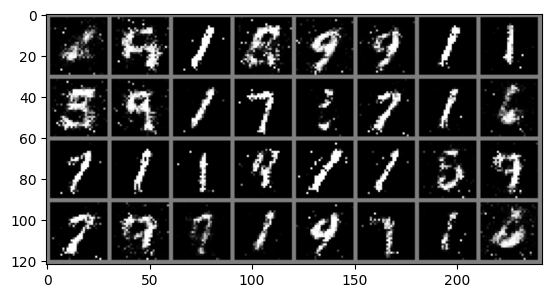

Epoch: 13 Loss D.: 0.3365928530693054
Epoch: 13 Loss G.: 1.665303111076355


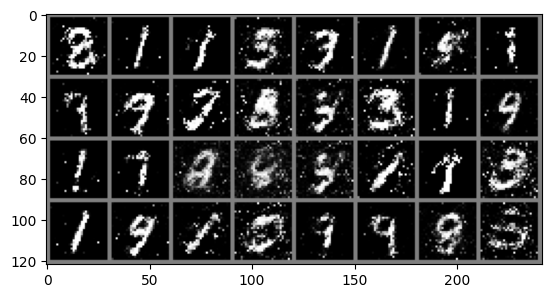

Epoch: 14 Loss D.: 0.44282984733581543
Epoch: 14 Loss G.: 1.5208393335342407


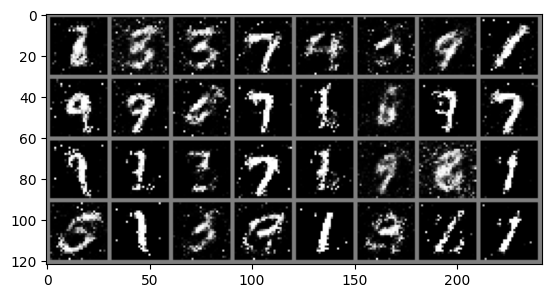

Epoch: 15 Loss D.: 0.34039193391799927
Epoch: 15 Loss G.: 1.3850986957550049


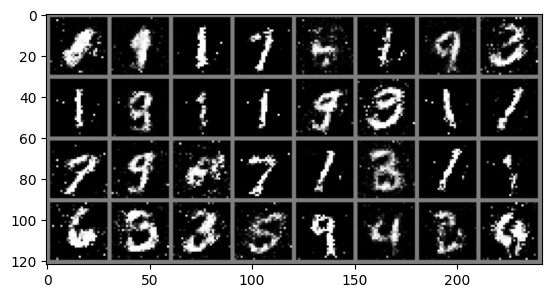

Epoch: 16 Loss D.: 0.4383243918418884
Epoch: 16 Loss G.: 1.4780725240707397


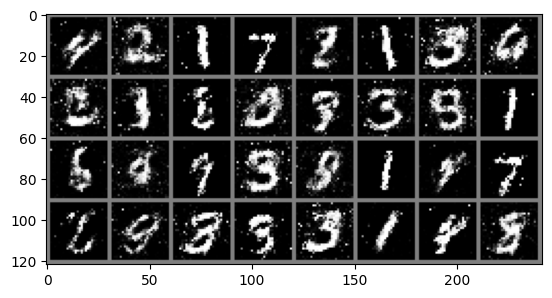

Epoch: 17 Loss D.: 0.465015172958374
Epoch: 17 Loss G.: 1.1130787134170532


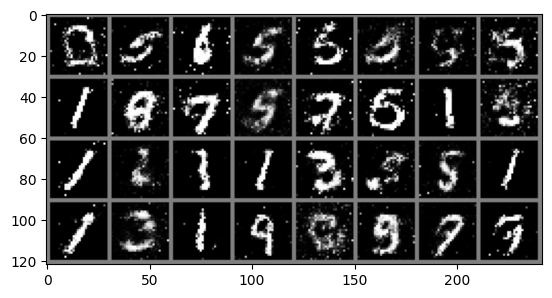

Epoch: 18 Loss D.: 0.4067171812057495
Epoch: 18 Loss G.: 1.3378446102142334


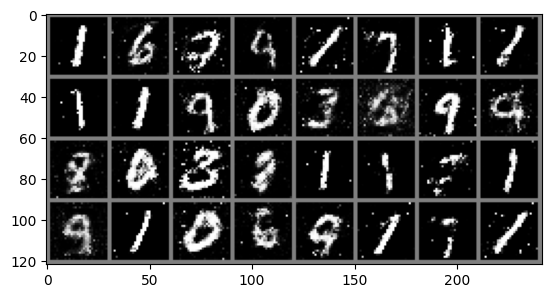

Epoch: 19 Loss D.: 0.41905897855758667
Epoch: 19 Loss G.: 1.3321082592010498


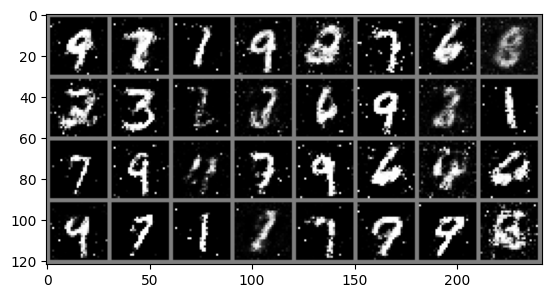

Epoch: 20 Loss D.: 0.3970346748828888
Epoch: 20 Loss G.: 1.2900915145874023


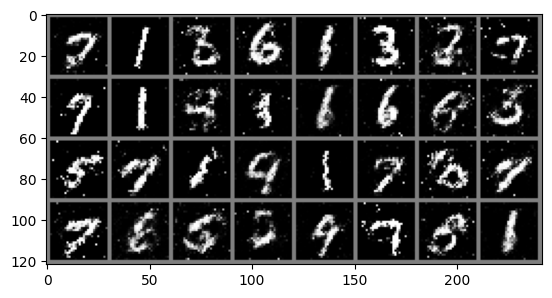

Epoch: 21 Loss D.: 0.5389615297317505
Epoch: 21 Loss G.: 1.260311484336853


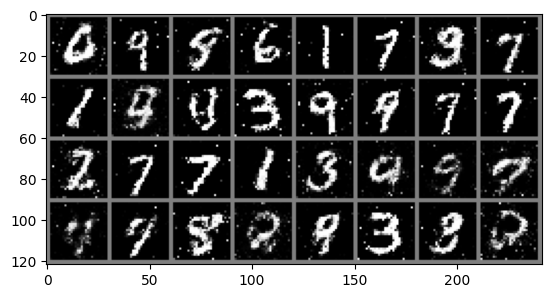

Epoch: 22 Loss D.: 0.46329498291015625
Epoch: 22 Loss G.: 1.2281357049942017


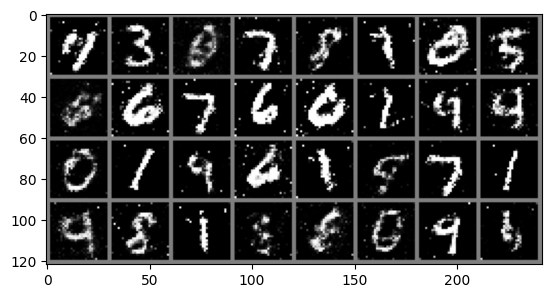

Epoch: 23 Loss D.: 0.4519490599632263
Epoch: 23 Loss G.: 1.3301663398742676


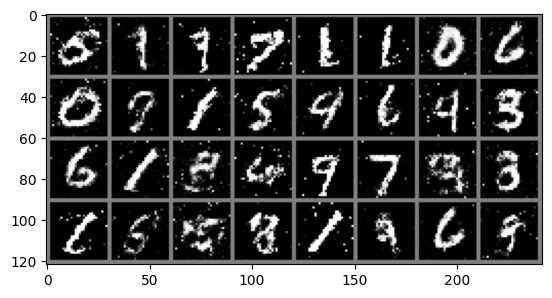

Epoch: 24 Loss D.: 0.614467978477478
Epoch: 24 Loss G.: 1.0231508016586304


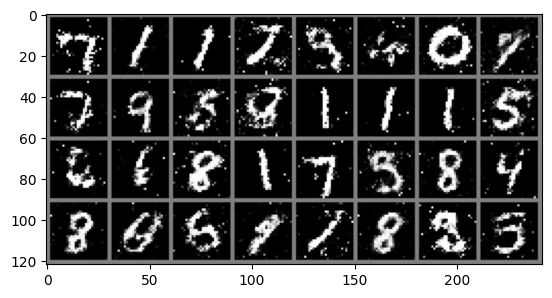

Epoch: 25 Loss D.: 0.43726861476898193
Epoch: 25 Loss G.: 1.138002634048462


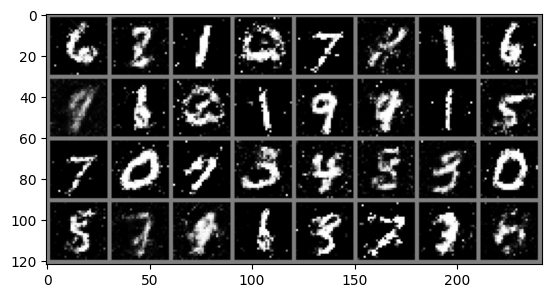

Epoch: 26 Loss D.: 0.4209008812904358
Epoch: 26 Loss G.: 1.3040924072265625


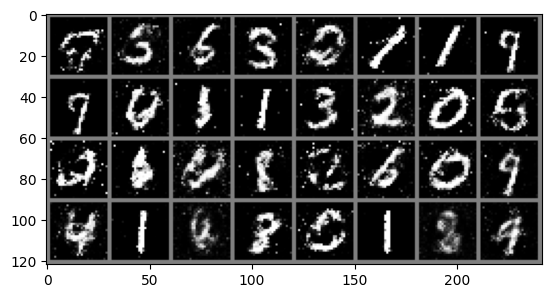

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            
            imshow(torchvision.utils.make_grid(generated_samples.cpu()))

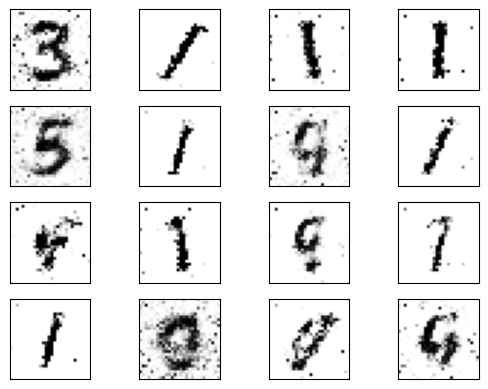

In [123]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])